### Homework: going neural (6 pts)

We've checked out statistical approaches to language models in the last notebook. Now let's go find out what deep learning has to offer.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/expanding_mind_lm_kn_3.png' width=300px>

We're gonna use the same dataset as before, except this time we build a language model that's character-level, not word level. Before you go:
* If you haven't done seminar already, use `seminar.ipynb` to download the data.
* This homework uses Pytorch v1.x: this is [how you install it](https://pytorch.org/get-started/locally/); and that's [how you use it](https://github.com/yandexdataschool/Practical_RL/tree/9f89e98d7df7ad47f5d6c85a70a38283e06be16a/week04_%5Brecap%5D_deep_learning).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Working on character level means that we don't need to deal with large vocabulary or missing words. Heck, we can even keep uppercase words in text! The downside, however, is that all our sequences just got a lot longer.

However, we still need special tokens:
* Begin Of Sequence  (__BOS__) - this token is at the start of each sequence. We use it so that we always have non-empty input to our neural network. $P(x_t) = P(x_1 | BOS)$
* End Of Sequence (__EOS__) - you guess it... this token is at the end of each sequence. The catch is that it should __not__ occur anywhere else except at the very end. If our model produces this token, the sequence is over.


In [2]:
BOS, EOS = ' ', '\n'

!wget "https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1" -O arxivData.json.tar.gz
!tar -xvzf arxivData.json.tar.gz
data = pd.read_json("./arxivData.json")
data.sample(n=5)

# if you missed the seminar, download data here - https://yadi.sk/d/_nGyU2IajjR9-w

--2022-02-20 09:08:07--  https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz [following]
--2022-02-20 09:08:08--  https://www.dropbox.com/s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4d282c54f30428c991e1afddf4.dl.dropboxusercontent.com/cd/0/get/BgFuP5hWr_qFCVrojv1BsYMneNTk0QcvOU6cbZ6EzIKLYPTVCmC9HJIZD8GuZgiDrew3plq2TuMByILVZMM4od4wEr_SI2hz_TY2Ue1l-QN0281Y7bUiBEanCHHG9yEbMzM544prOiOTrUFGCNtNiMLD/file?dl=1# [following]
--2022-02-20 09:08:09--  https://uc4d282c54f30428c991e1afddf4.dl.dropboxusercontent.com/cd/0/get/BgFuP5hWr_qFCVrojv1BsYMneNTk0QcvOU6cbZ6EzIKLYPTVCmC9HJIZD8

,author,day,id,link,month,summary,tag,title,year
25828,"[{'name': 'Amir Ghodrati'}, {'name': 'Xu Jia'}...",26,1511.08446v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",11,Learning the distribution of images in order t...,"[{'term': 'cs.CV', 'scheme': 'http://arxiv.org...",Towards Automatic Image Editing: Learning to S...,2015
2573,"[{'name': 'Marco F Cusumano-Towner'}, {'name':...",31,1606.00068v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",5,This paper introduces a new technique for quan...,"[{'term': 'cs.AI', 'scheme': 'http://arxiv.org...",Quantifying the probable approximation error o...,2016
25878,"[{'name': 'Adrian Popescu'}, {'name': 'Etienne...",7,1512.02013v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",12,Convolutional neural networks (CNNs) tend to b...,"[{'term': 'cs.CV', 'scheme': 'http://arxiv.org...",Scalable domain adaptation of convolutional ne...,2015
385,"[{'name': 'Konstantinos Chatzilygeroudis'}, {'...",20,1709.06917v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",9,The most data-efficient algorithms for reinfor...,"[{'term': 'cs.RO', 'scheme': 'http://arxiv.org...",Using Parameterized Black-Box Priors to Scale ...,2017
6201,"[{'name': 'Andrés Hoyos-Idrobo'}, {'name': 'Ga...",15,1609.04608v2,"[{'rel': 'related', 'href': 'http://dx.doi.org...",9,"In this work, we revisit fast dimension reduct...","[{'term': 'stat.ML', 'scheme': 'http://arxiv.o...",Recursive nearest agglomeration (ReNA): fast c...,2016


In [3]:
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:512], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

Our next step is __building char-level vocabulary__. Put simply, you need to assemble a list of all unique tokens in the dataset.

In [127]:
# get all unique characters from lines (including capital letters and symbols)
tokens = np.unique(list(' '.join(lines)))


tokens = sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens

n_tokens =  136


We can now assign each character with it's index in tokens list. This way we can encode a string into a torch-friendly integer vector.

In [128]:
# dictionary of character -> its identifier (index in tokens list)
token_to_id = {token: i for i, token in enumerate(tokens)}

In [129]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


Our final step is to assemble several strings in a integet matrix `[batch_size, text_length]`. 

The only problem is that each sequence has a different length. We can work around that by padding short sequences with extra _EOS_ or cropping long sequences. Here's how it works:

In [7]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype=np.int64):
    """Casts a list of lines into torch-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [130]:
#Example: cast 4 random names to matrices, pad with zeros
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))

[[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]


### Neural Language Model (2 points including training)

Just like for N-gram LMs, we want to estimate probability of text as a joint probability of tokens (symbols this time).

$$P(X) = \prod_t P(x_t \mid x_0, \dots, x_{t-1}).$$ 

Instead of counting all possible statistics, we want to train a neural network with parameters $\theta$ that estimates the conditional probabilities:

$$ P(x_t \mid x_0, \dots, x_{t-1}) \approx p(x_t \mid x_0, \dots, x_{t-1}, \theta) $$


But before we optimize, we need to define our neural network. Let's start with a fixed-window (aka convolutional) architecture:

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/fixed_window_lm.jpg' width=400px>


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [131]:
class FixedWindowLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=64):
        """ 
        A fixed window model that looks on at least 5 previous symbols.
        
        Note: fixed window LM is effectively performing a convolution over a sequence of words.
        This convolution only looks on current and previous words.
        Such convolution can be represented as a sequence of 2 operations:
        - pad input vectors by {strides * (filter_size - 1)} zero vectors on the "left", do not pad right
        - perform regular convolution with {filter_size} and {strides}
        
        - If you're absolutely lost, here's a hint: use nn.ZeroPad2d((NUM_LEADING_ZEROS, 0, 0, 0))
          followed by a nn.Conv1d(..., padding=0). And yes, its okay that padding is technically "2d".
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        
        self.emb = nn.Embedding(n_tokens, emb_size)      
        self.pad = nn.ZeroPad2d((4, 0, 0, 0)) # 1 * (5 - 1)
        self.cnv = nn.Conv1d(emb_size, hid_size, kernel_size = 5)
        self.fc = nn.Linear(hid_size, n_tokens)
    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
            
        :note: that convolutions operate with tensors of shape [batch, channels, length], while linear layers
         and *embeddings* use [batch, length, channels] tensors. Use tensor.permute(...) to adjust shapes.

        """

        padding = self.pad(input_ix)
        embedding = self.emb(padding)
        embedding = torch.permute(embedding, (0, 2, 1))
        conv = self.cnv(embedding)
        conv = torch.permute(conv, (0, 2, 1))
        linlayer = self.fc(conv)
        
        return linlayer # output tensor should be of shape [batch_size, sequence_length, n_tokens]
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64, device=DEVICE)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))
        

In [11]:
DEVICE = 'cuda:0'

In [12]:
dummy_model = FixedWindowLanguageModel().to(DEVICE)

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines), device=DEVICE)
dummy_logits = dummy_model(dummy_input_ix)

print('Weights:', tuple(name for name, w in dummy_model.named_parameters()))

Weights: ('emb.weight', 'cnv.weight', 'cnv.bias', 'fc.weight', 'fc.bias')


In [13]:
assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits.data.cpu().numpy())), "inf/nan encountered"
assert not np.allclose(dummy_logits.data.cpu().numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [14]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]), device=DEVICE)
dummy_logits_2 = dummy_model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

We can now tune our network's parameters to minimize categorical crossentropy over training dataset $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

As usual with with neural nets, this optimization is performed via stochastic gradient descent with backprop.  One can also note that minimizing crossentropy is equivalent to minimizing model __perplexity__, KL-divergence or maximizng log-likelihood.

In [15]:
def compute_mask(input_ix, eos_ix=token_to_id[EOS]):
    """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
    return F.pad(torch.cumsum(input_ix == eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True).to(DEVICE)

print('matrix:\n', dummy_input_ix.cpu().numpy())
print('mask:', compute_mask(dummy_input_ix).to(torch.int32).cpu().numpy())
print('lengths:', compute_mask(dummy_input_ix).sum(-1).cpu().numpy())

matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
mask: [[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
lengths: [ 5  9 15]


In [132]:
def compute_loss(model, input_ix):
    """
    :param model: language model that can compute next token logits given token indices
    :param input ix: int32 matrix of tokens, shape: [batch_size, length]; padded with eos_ix
    :returns: scalar loss function, mean crossentropy over non-eos tokens
    """
    input_ix = torch.as_tensor(input_ix, dtype=torch.int64, device=DEVICE)
    
    logits = model(input_ix[:, :-1])
    reference_answers = input_ix[:, 1:]

    probs = F.log_softmax(logits, dim = -1)
    mask = compute_mask(reference_answers).to(DEVICE)
    mask_probs = torch.gather(probs, dim=-1, index=reference_answers.unsqueeze(dim=-1)).squeeze(-1) * mask
    sum_probs = - mask_probs.sum()
    loss = sum_probs / input_ix.shape[0]
    
    return loss   

In [17]:
loss_1 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=15))
loss_2 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=16))
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert torch.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. '\
    'Hint: use compute_mask. Beware +/-1 errors. And be careful when averaging!'

### Evaluation

You will need two functions: one to compute test loss and another to generate samples. For your convenience, we implemented them both in your stead.

In [34]:
def score_lines(model, dev_lines, batch_size):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    with torch.no_grad():
        for i in range(0, len(dev_lines), batch_size):
            batch_ix = to_matrix(dev_lines[i: i + batch_size])
            dev_loss_num += compute_loss(model, batch_ix).item() * len(batch_ix)
            dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

def generate(model, prefix=BOS, temperature=1.0, max_len=100):
    """
    Samples output sequence from probability distribution obtained by model
    :param temperature: samples proportionally to model probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    with torch.no_grad():
        while True:
            token_probs = model.get_possible_next_tokens(prefix)
            tokens, probs = zip(*token_probs.items())
            if temperature == 0:
                next_token = tokens[np.argmax(probs)]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(tokens, p=probs)

            prefix += next_token
            if next_token == EOS or len(prefix) > max_len: break
    return prefix

### Training loop

Finally, let's train our model on minibatches of data

In [19]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []
model = FixedWindowLanguageModel().to(DEVICE)
opt = torch.optim.Adam(model.parameters())

# hint: if you ever wanted to switch to cuda, do it now.

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: Bridginglãóc)Lcσś+}sPQGD Év7üX- äTμσvètu+EíO7w,Πä!tK[:+E8őαt^VνxKC=$Qá%ρ3)D3 τæà Yè>6ρ1^IQσiR\I^PÖ"v


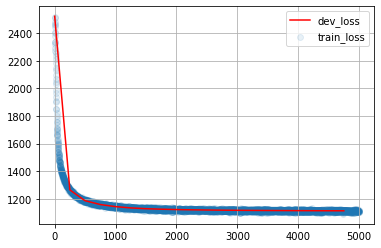

Generated examples (tau=0.5):
 Ond taris tor mate nomplome the dith inion the mentian ly formation sion  formection tha dingly. Thi
 De porearion and contion a por and thes in probetion the thal mouth iogroncaldicasery and ancentitio
 A Ment des and coustin and iner ase cons mouthis se the chase pereconite serane conver at ons pares 
Scoring dev...


100%|██████████| 5000/5000 [04:55<00:00, 16.94it/s]

#4999 Dev loss: 1112.088


In [20]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
       
    loss_i = compute_loss(model, batch)
    
    opt.zero_grad()
    loss_i.backward()
    opt.step()
        
    train_history.append((i, loss_i.item()))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [21]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])

for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 1112.0881266196645
 Extore neralis and of en we precally an ual anowith of amedes the setrection that reproblement and o
 Exparet on se porel chis tive compation of a thes sof andermanting of the pereation the s ant extori
 A Proficines in the ser beded comperes an buation ther prestion sed the twork, works work fer betion
 Extatimize s one the prouthe porection probe town the s ars the hat intor ate sure ffor the proel co
 Deare the ration suat on al on worustima formextrons are nowe d ar rever ate mol mathe camprion the 
 In reathe suan ing the mpored (CNN) were semont ding ing nos te sente sef can beticte the ation asti
 Learis and Le fure the spange the for the searel tron derale ser oficl preas are dorul the che thes 
 A Serthe paral orale sed seato probol teximble thed the prestinis an aral texteron the derent mont a
 Ontimaly and wed and cation the sempreat ons are tho aption bolution for chive the menthe anderatin 
 Angrom se perel ter cand al os an explitition 

### RNN Language Models (3 points including training)

Fixed-size architectures are reasonably good when capturing short-term dependencies, but their design prevents them from capturing any signal outside their window. We can mitigate this problem by using a __recurrent neural network__:

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$

Such model processes one token at a time, left to right, and maintains a hidden state vector between them. Theoretically, it can learn arbitrarily long temporal dependencies given large enough hidden size.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/rnn_lm.jpg' width=480px>

In [133]:
class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=256):
        """ 
        Build a recurrent language model.
        You are free to choose anything you want, but the recommended architecture is
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits
        
        :note: if you use nn.RNN/GRU/LSTM, make sure you specify batch_first=True
         With batch_first, your model operates with tensors of shape [batch_size, sequence_length, num_units]
         Also, please read the docs carefully: they don't just return what you want them to return :)
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        self.n_hidden = hid_size
        
        self.emb = nn.Embedding(n_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, hid_size, batch_first=True)
        self.act = nn.LeakyReLU()
        self.fc = nn.Linear(self.n_hidden, n_tokens)

    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
            
        """
        x = self.emb(input_ix)
        out, hid = self.rnn(x)
        out = self.act(out)
        out = self.fc(out)

        return out # output tensor should be of shape [batch_size, sequence_length, n_tokens]
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64, device=DEVICE)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))
        

In [23]:
model = RNNLanguageModel().to(DEVICE)

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines), device=DEVICE)
dummy_logits = model(dummy_input_ix)

assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert not np.allclose(dummy_logits.cpu().data.numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"
print('Weights:', tuple(name for name, w in model.named_parameters()))

Weights: ('emb.weight', 'rnn.weight_ih_l0', 'rnn.weight_hh_l0', 'rnn.bias_ih_l0', 'rnn.bias_hh_l0', 'fc.weight', 'fc.bias')


In [24]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]), device=DEVICE)
dummy_logits_2 = model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

### RNN training

Our RNN language model should optimize the same loss function as fixed-window model. But there's a catch. Since RNN recurrently multiplies gradients through many time-steps, gradient values may explode, [ruining](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/nan.jpg) your model.
The common solution to that problem is to clip gradients either [individually](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_value) or [globally](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_global_norm).

Your task here is to implement the training code that minimizes the loss function. If you encounter large loss fluctuations during training, please add [gradient clipping](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html) using urls above. But its **not necessary** to use gradient clipping if you don't need it.

_Note: gradient clipping is not exclusive to RNNs. Convolutional networks with enough depth often suffer from the same issue._

In [25]:
batch_size = 64         # <-- please tune batch size to fit your CPU/GPU configuration
score_dev_every = 250
train_history, dev_history = [], []

model = RNNLanguageModel().to(DEVICE)
opt = torch.optim.Adam(model.parameters())

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: BridgingaZBzτææç8σχyehs]^f;l71Lè<)ΩPqj=~É°mlàMcDv;@Sq6õvλαó-ó'{(ZνW(>qσ|>cΩTQ@ROnnN@bQ[α__Σ]_ã>-_zMm


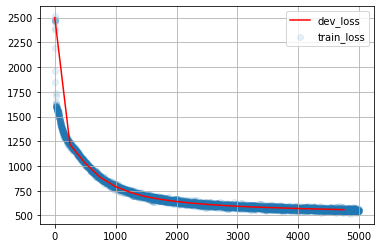

Generated examples (tau=0.5):
 Processing Domain Recognition on Stochastic Distribution   Shape ; In this paper, we propose a new a
 A Multiple Deep Relations for Multi-Lauge Translation ; In this paper, we propose a method for deep 
 Semi-Supervised Feature Analysis of Selective Semantic Approach ; We present a new weights are are p
Scoring dev...


100%|██████████| 5000/5000 [16:34<00:00,  5.03it/s]

#4999 Dev loss: 555.122


In [26]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))

    loss_i = compute_loss(model, batch)
    
    opt.zero_grad()
    loss_i.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 10)
    opt.step()
    
    train_history.append((i, float(loss_i)))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [41]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(10):
  print(generate(model, temperature=0.5))

Final dev loss: 555.12205791492
 Towards an Experimental Convolutional Neural Networks for Recognition ; The complex method for state
 Statistical Planning and Study in Partial Metric ; The algorithm is a completeness of interpolation 
 On three faping a language for a corpus for recent and results ; We present a novel feature and opti
 A Optimization and Object Convolutional Neural Network ; Convergence and the one of the problem of p
 A Posterior Filtering ; We propose a semantic problem in the outcomes such as a deep network structu
 A Convolutional Anomalization of Probabilistic Processes ; We present a novel artificial neural netw
 Deep Learning for Deep Learning in Answer Detection ; We extract the problem of generalized data set
 A State Convolutional Neural Networks ; The recognition (LD) is a new problem of the logic residual 
 Convex Planning in English Composition ; This paper introduces the parameters to many and problem is
 A Directed Recognition of Prediction of A Facial 

### Alternative sampling strategies (1 point)

So far we've sampled tokens from the model in proportion with their probability.
However, this approach can sometimes generate nonsense words due to the fact that softmax probabilities of these words are never exactly zero. This issue can be somewhat mitigated with sampling temperature, but low temperature harms sampling diversity. Can we remove the nonsense words without sacrificing diversity? __Yes, we can!__ But it takes a different sampling strategy.

__Top-k sampling:__ on each step, sample the next token from __k most likely__ candidates from the language model.

Suppose $k=3$ and the token probabilities are $p=[0.1, 0.35, 0.05, 0.2, 0.3]$. You first need to select $k$ most likely words and set the probability of the rest to zero: $\hat p=[0.0, 0.35, 0.0, 0.2, 0.3]$ and re-normalize: 
$p^*\approx[0.0, 0.412, 0.0, 0.235, 0.353]$.

__Nucleus sampling:__ similar to top-k sampling, but this time we select $k$ dynamically. In nucleous sampling, we sample from top-__N%__ fraction of the probability mass.

Using the same  $p=[0.1, 0.35, 0.05, 0.2, 0.3]$ and nucleous N=0.9, the nucleous words consist of:
1. most likely token $w_2$, because $p(w_2) < N$
2. second most likely token $w_5$, $p(w_2) + p(w_5) = 0.65 < N$
3. third most likely token $w_4$ because $p(w_2) + p(w_5) + p(w_4) = 0.85 < N$

And thats it, because the next most likely word would overflow: $p(w_2) + p(w_5) + p(w_4) + p(w_1) = 0.95 > N$.

After you've selected the nucleous words, you need to re-normalize them as in top-k sampling and generate the next token.

__Your task__ is to implement nucleus sampling variant and see if its any good.

In [120]:
def generate_nucleus(model, prefix=BOS, nucleus=0.9, max_len=100):
    """
    Generate a sequence with nucleous sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formulae above, N \in [0, 1]
    :param max_len: generate sequences with at most this many tokens, including prefix
    
    :note: make sure that nucleous always contains at least one word, even if p(w*) > nucleus
    
    """
    cur_sum = 0
    i = 0
    nucl_probs = np.array([])

    while True:
        token_probs = model.get_possible_next_tokens(prefix)
        token_probs = sorted(token_probs.items(), key=lambda x: x[1], reverse=True)
        tokens, probs = zip(*token_probs)

        if (cur_sum < nucleus):
          cur_sum += probs[i]
          i += 1

        nucl_probs = probs[:i] / np.sum(probs[:i])
        next_token = np.random.choice(tokens[:i], p=nucl_probs)
    
        prefix += next_token
        if next_token == EOS or len(prefix) > max_len: break
    return prefix

In [121]:
for i in range(10):
    print(generate_nucleus(model, nucleus=0.9))

 A Semi-Stocial Multi-Policy Visually Developmental Squal Divergences (NUS) ; The introduced represen
 A Survey Detection Using Twiese Underlying Uncuition Registantic Semanding ; K Nenning achieving nov
 An End-to-end Neural Gard System and Large-dynamic Heuristic Slights, Real-time Seriet   Media attac
 An Anound-becomes for Method Repontruptors ; Himers between time, elmarkological works tool. In this
 A Consistentic Obigularity of Cross-Occellinc Convex-RPP metric Glogenelle Sparse Graph ; Dilimate a
 A Spectral Algorithms for Decoder Pices Thus Model ; In particularly and verification unisons on sof
 A Commurich Sampled Dlight for Learning Time ; What receive: While itime sensor distributions. The w
 A Correlative Signal Manifold Based Detection for Mattem Edvances ; Chinese mainle communications by
 A Convolutional Networks and Plaig Toking for Particle Sector ; The semantic action Methods for segm
 A Dirersutional Face Disambing ; In this paper, we created a solthm rise units is